In [6]:
# Written by Dr. Keith Knipling, US NRL MSTD
# Included in Github for reference, will need to integrate into application
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4.5,3.2]

## Atomic/weight percent converter

In [7]:
from hyperspy.misc.elements import elements as elements_db
#from hyperspy.misc.eds.ffast_mac import ffast_mac_db as ffast_mac
from hyperspy.misc.eds import utils as utils_eds
from hyperspy.misc.utils import stack

def weight_to_atomic(weight_percent, elements):
    """Convert weight percent (wt%) to atomic percent (at.%).

    Parameters
    ----------
    weight_percent: array of float
        The weight fractions (composition) of the sample.
    elements: list of str
        A list of element abbreviations, e.g. ['Al','Zn']

    Returns
    -------
    atomic_percent : array of float
        Composition in atomic percent.

    Calculate the atomic percent of modern bronze given its weight percent:
    >>> hs.material.weight_to_atomic((88, 12), ("Cu", "Sn"))
    array([ 93.19698614,   6.80301386])

    """
    if len(elements) != len(weight_percent):
        raise ValueError(
            'The number of elements must match the size of the first axis'
            'of weight_percent.')
    atomic_weights = np.array(
        [elements_db[element]['General_properties']['atomic_weight']
            for element in elements])
    atomic_percent = np.array(
        list(map(np.divide, weight_percent, atomic_weights)))
    sum_weight = atomic_percent.sum(axis=0) / 100.
    for i, el in enumerate(elements):
        atomic_percent[i] /= sum_weight
        atomic_percent[i] = np.where(sum_weight == 0.0, 0.0, atomic_percent[i])
    return atomic_percent


def atomic_to_weight(atomic_percent, elements):
    """Convert atomic percent to weight percent.
 
    Parameters
    ----------
    atomic_percent: array
        The atomic fractions (composition) of the sample.
    elements: list of str
        A list of element abbreviations, e.g. ['Al','Zn']
 
    Returns
    -------
    weight_percent : array of float
        composition in weight percent.
 
    Examples
    --------
    Calculate the weight percent of modern bronze given its atomic percent:
    >>> hs.material.atomic_to_weight([93.2, 6.8], ("Cu", "Sn"))
    array([ 88.00501989,  11.99498011])
 
    """
    if len(elements) != len(atomic_percent):
        raise ValueError(
            'The number of elements must match the size of the first axis'
            'of atomic_percent.')
    atomic_weights = np.array(
        [elements_db[element]['General_properties']['atomic_weight']
            for element in elements])
    weight_percent = np.array(
        list(map(np.multiply, atomic_percent, atomic_weights)))
    sum_atomic = weight_percent.sum(axis=0) / 100.
    for i, el in enumerate(elements):
        weight_percent[i] /= sum_atomic
        weight_percent[i] = np.where(sum_atomic == 0.0, 0.0, weight_percent[i])
    return weight_percent

## Nominal composition of alloy

In [8]:
# Nominal composition of 10Ni steel in wt.%
elements = ['C', 'Ni', 'Mo', 'V', 'Mn', 'Cr', 'Fe']
alloy_weight_percent = [0.1, 10, 1.0, 0.08, 0.60, 0.60, 87.62]

In [9]:
alloy_atomic_percent = weight_to_atomic(alloy_weight_percent, elements)

alloy = pd.DataFrame({'Element': elements,'wt.%': alloy_weight_percent,'at.%': alloy_atomic_percent.round(2)})
alloy = alloy[['Element','wt.%','at.%']]
alloy.sort_values(by='at.%', ascending=False, inplace = True)
alloy = alloy.T
alloy

,6,1,5,4,2,0,3
Element,Fe,Ni,Cr,Mn,Mo,C,V
wt.%,87.62,10.0,0.6,0.6,1.0,0.1,0.08
at.%,88.04,9.56,0.65,0.61,0.58,0.47,0.09


## Elements of interest

In [10]:
elements = ['Fe', 'Ni', 'Cr', 'Mn', 'Mo', 'C', 'V', 'Cu', 'Si', 'Ti']
overlaps = ['Sc', 'Y']
colors = {
    'Fe': '#3F3F3F',
    'Ni': '#00A000',
    'Cr': '#6400A0',
    'Mn': '#008080',
    'Mo': '#C80000',
    'C': '#000000',
    'V': '#1478B4',
    'Cu': '#FF8000',
    'Si': '#CCCCCC',
    'Ti': '#643C00'
}

## Overlaps

With this steel, there are overlapping peaks at 24 Da (Ti and C2) and 25 Da (Cr, Ti, V, and C2). The degree of overlap depends on what phase is being analyzed. Part of the functionality in this notebook is to decompose these peaks based on the unamibiguously windowed neighboring peaks of these various species.

### Entire analysis

Overlaps in the entire analysis of R41_01488.

![title](R41_01488_overlaps.PNG)

### Carbides

Overlaps in the Mo, Cr, Ti-rich carbides of R41_01488. Here, 25 Da seems to be mostly Ti.

![R41_01488 carbides](R41_01488_carbides_mass_spec.PNG)

## Functions

In [11]:
def composition(df):
    composition = 100*df.div(df.sum(axis=1), axis=0)
    return composition


def uncertainty(df):
    uncertainty = 100*df.div(df.sum(axis=1), axis=0)*(100-100*df.div(df.sum(axis=1), axis=0)).div(df.sum(axis=1), axis=0)
    uncertainty = uncertainty**.5
    return uncertainty


from math import log10, floor

# places(0.0003) = 4
def places(x):
    if x > 0:
        return -int(floor(log10(abs(x))))
    else:
        return 0

def round_to_place(x):
    return round(x, places(x))


def ion_counts_file(datafile, elements, **kwargs):

    count_type = kwargs.get('count_type', None)

    if count_type:
        count_type = count_type
    else:
        count_type = 'Decomposed Count'

    data = pd.read_csv(datafile, skiprows=1)
    data = data.set_index('Ion Type')
    df = data.loc[elements][count_type]

#     df = df.sort_values(ascending = False)

    df = pd.DataFrame(df).T
#     df['Total (ions in M)'] = df.sum(axis=1)/1e6

    df.index = ['Counts']
    return df




# For Ti, we are windowing 46, 47, and 49, or 21.1% of it (8.25 + 7.44 + 5.41)

# So, inflate that measured Ti by
# 100/(8.25+7.44+5.41) = 4.739
# to get total Ti.

# ti is measured ti
def ti_total(ti):
    total = 100/(8.25+7.44+5.41)*ti
    return total


# For Cr, we are windowing 26 and 26.5, or 93.29% of it (83.789+9.501)

# So, inflate that measured Cr by
# 100/(83.789+9.501) = 1.072
# to get total Cr.

# cr is measured cr
def cr_total(cr):
    total = 100/(83.789 + 9.501) * cr
    return total


# For V, we are windowing 25.5, or 99.75% of it

# So, inflate that measured V by
# 100/99.75 = 1.003
# to get total V.

# v is measured v
def v_total(v):
    total = 100/99.75*v
    return total



# The Ti in the 24 peak is 73.72% of the total

# So carbon in 24 peak is
# 2*( [Atoms in 24 peak] - .7372*[total Ti] )

# sc is what is measured in 24 Da peak

def ti_in_twentyfour(ti):
    return ti_total(ti) * 73.72/100

# Any excess in the 24 Da peak is C2. That peak is windowed as 'Y'
def c_in_twentyfour(sc,ti):
    return 2 * ( sc - ti_in_twentyfour(ti) )


# The Ti in the 25 peak is 5.18% of the total, so
# 100/(8.25+7.44+5.41)*.0518 = 0.245
# of the measured Ti
# Likewise for Cr and V

# So C in 25 peak is
# [Atoms in 25 peak] - 0.245*[measured Ti] )

# y is what is measured in 25 Da peak
# ti is the measured ti
# cr is the measured cr
# v is the measured v
# The expectation is that 25 Da is mostly Ti in the carbides

def ti_in_twentyfive(ti):
    return ti_total(ti) * 5.18/100

def cr_in_twentyfive(cr):
    return cr_total(cr) * 4.345/100

def v_in_twentyfive(v):
    return v_total(v) * .25/100

# Any excess in the 25 Da peak is C2. 25 Da peak is windowed as 'Y'
def c_in_twentyfive(y, ti, cr, v):
    return 2 * ( y - ti_in_twentyfive(ti) - cr_in_twentyfive(cr) - v_in_twentyfive(v) )



def counts_decompose_overlaps_check(df):
    # Otherwise function will overwrite argument
    df = df.copy()
    df['Cr in 25Da'] = df.apply(lambda x: cr_in_twentyfive(x['Cr']), axis=1)
    df['Ti in 25Da'] = df.apply(lambda x: ti_in_twentyfive(x['Ti']), axis=1)
    df['V in 25Da'] = df.apply(lambda x: v_in_twentyfive(x['V']), axis=1)
    df['C in 25Da'] = df.apply(lambda x: c_in_twentyfive(x['Y'], x['Ti'], x['Cr'], x['V']), axis=1)
    # Only add to C count if positive
    df['C in 25Da'] = (df['C in 25Da'] + abs(df['C in 25Da']) )/2

    # When this is positive, we are pumping more atoms into the peak than are measured. We also do not adding any C.
    df['25Da excess'] = df['Cr in 25Da'] + df['Ti in 25Da'] + df['V in 25Da'] - df['Y']

    df['Ti in 24Da'] = df.apply(lambda x: ti_in_twentyfour(x['Ti']), axis=1)

    df['C in 24Da'] = df.apply(lambda x: c_in_twentyfour(x['Sc'], x['Ti']), axis=1)
    # Only add to C count if positive
    df['C in 24Da'] = (df['C in 24Da'] + abs(df['C in 24Da']) )/2

    # When this is positive, we are pumping more atoms into the peak than are measured. We also are not adding any C.
    df['24Da excess'] = df['Ti in 24Da'] - df['Sc']

    df.drop(['Sc','Y'], axis=1, inplace = True)
    if 'Total (ions in M)' in df.columns:
        df.drop(['Total (ions in M)'], axis=1, inplace = True)

        df.reset_index(drop=True, inplace=True)
        
    return df



def counts_decompose_overlaps(df):
    # Otherwise function will overwrite argument
    df = df.copy()

    df = counts_decompose_overlaps_check(df)

    df['Cr'] = df['Cr'] + df['Cr in 25Da']
    df['Ti'] = df['Ti'] + df['Ti in 24Da'] + df['Ti in 25Da']
    df['V'] = df['V']   + df['V in 25Da']
    df['C'] = df['C']   + df['C in 24Da']  + df['C in 25Da']

    df.drop(['C in 24Da', 'C in 25Da', 'Cr in 25Da', 'Ti in 24Da', 'Ti in 25Da', 'V in 25Da','24Da excess','25Da excess'], axis=1, inplace = True)

    return df




def bulk(df, **kwargs):
    df = df.copy()
    
    sorted = kwargs.get('sorted', None)

    if sorted:
        df.sort_values(by = 'Counts', axis = 1, ascending = False, inplace = True)

    total_ions = round(df.sum(axis=1)/1e6,2).values[0]
    df.index = ['Counts (' + str(total_ions) + ' M ions)']


    comp = composition(df)
    comp.index = ['Composition (%)']

    unc = uncertainty(df)
    unc.index = ['Uncertainty (%)']

    comp_list = comp.loc['Composition (%)']
    unc_list = unc.loc['Uncertainty (%)']

    # Rounded uncertainties
    unc_r = list(map(lambda x: round_to_place(x), unc_list))

    # Uncertainties to one digit
    unc_last = list(map(lambda x: round(round_to_place(x)*10**places(x)), unc_list))

    # Decimal places to round to
    pl = list(map(lambda x: places(x), unc_list))

    # Rounded compositions. TODO: fix rounding up/down
#     https://stackoverflow.com/questions/19986662/rounding-a-number-in-python-but-keeping-ending-zeros
    comp_r = [format(comp_list[i],"."+str(pl[i])+"f") for i in range(len(comp_list))]
    # comps_r = [format(round(comps[i],pl[i]),"."+str(pl[i])+"f") for i in range(len(comps))]
    

    report = pd.DataFrame([str(comp_r[i]) + '(' + str(round(unc_last[i])) + ')' for i in range(len(comp_list))]).T
    report.columns = df.columns
    report.index = ['Report']

    bulk = pd.concat([df,comp,unc,report])


    return bulk



# Calculated from ion counts
def plateau(df, xmin, xmax, **kwargs):
    sorted = kwargs.get('sorted', None)

    # Remove uncertainty columns
    df = df[df.columns.drop(list(df.filter(regex='unc')))]
    df = df[xmin:xmax]

    df = df.sum(axis = 0)
    df = pd.DataFrame(df).T

    if sorted:
        return bulk(df).sort_values(by = 'Composition (%)', axis = 1, ascending = False)
    else:
        return bulk(df)




def proxigram_counts_file(datafile, elements, **kwargs):
    df = pd.read_csv(datafile)

    bg_corrected = kwargs.get('bg_corrected', None)

    if bg_corrected:
        element_headings = [s + ' % correctd' for s in elements]
    else:
        element_headings = [s + ' %' for s in elements]

    counts = df[element_headings]

    counts.columns = elements

    decimals = 1
    df['Distance (nm)'] = df['Distance (nm)'].apply(lambda x: round(x, decimals))

    df = pd.DataFrame(df['Distance (nm)']).join(counts[elements])

    df.set_index("Distance (nm)", inplace = True)

    return df



def proxigram(df):

    conc = composition(df)
    unc = uncertainty(df)

    elements = list(df.columns)

    element_headings = [s + ' %' for s in elements]
    uncertainty_headings = [s + ' % unc' for s in elements]

    conc.columns = element_headings
    unc.columns = uncertainty_headings

#     df = pd.DataFrame(df['Distance (nm)']).join(conc[element_headings])
    df = conc.join(unc[uncertainty_headings])

    return df



def proxigram_plot(df, **kwargs):

    errorbars = df.filter(regex='unc')
    errorbars.columns = [s.replace(' unc', '') for s in errorbars.columns]
    
#     Remove uncertainty columns
    df = df[df.columns.drop(list(df.filter(regex='unc')))]

    elements = list(df.columns)
    show = kwargs.get('show', None)
    xlim = kwargs.get('xlim', None)
    ylim = kwargs.get('ylim', None)

    if show:
        y = [s + ' %' for s in show]
    else:
        y = [s for s in elements]

    if xlim:
        if ylim:
            return df.plot(y = y, xlim = xlim, ylim = ylim, color=[colors.get(x.replace(' %', ''), '#333333') for x in y], yerr = errorbars)
        else:
            return df.plot(y = y, xlim = xlim, color=[colors.get(x.replace(' %', ''), '#333333') for x in y], yerr = errorbars)
    elif ylim:
        return df.plot(y = y, ylim = ylim, color=[colors.get(x.replace(' %', ''), '#333333') for x in y], yerr = errorbars)
    else:
        return df.plot(y = y, color=[colors.get(x.replace(' %', ''), '#333333') for x in y], yerr = errorbars)




# R41_01488

In [12]:
run = 'R41_01488'

## Bulk composition

In [15]:
file = 'Data/R41_01488-v01-bulk 24Da as B.csv'
file = 'Data/R41_01488-v01-bulk 24Da as B background corrected.csv'
file = 'Data/R41_01488-v01-bulk 24Da-as-Sc 25Da-as-Y background corrected.csv'

df = ion_counts_file(file, elements + overlaps)
raw_ion_counts = df.copy()
raw_ion_counts

Ion Type,Fe,Ni,Cr,Mn,Mo,C,V,Cu,Si,Ti,Sc,Y
Counts,4.250138e+07,2.785266e+06,220510.153693,107619.623451,98996.841603,20977.055759,16071.390521,28284.43506,188964.145203,690.052505,5132.480364,10308.982988


In [16]:
ti_in_twentyfour(df['Ti'][0]) / ( ti_in_twentyfour(df['Ti'][0]) + c_in_twentyfour(df['Sc'][0],df['Ti'][0]) )

0.30696759840167426

The 24 Da peak, Sc, is about 30% Ti globally.

![title](R41_01488_mass-spec.PNG)

In [17]:
cr_in_twentyfive(df['Cr'][0]) / df['Y'][0]

0.9962479865871288

No evidence for C in the 25 Da peak, Y. 25 Da peak is 99% Cr globally, consistent with peak decomposition in IVAS.

In [18]:
counts_decompose_overlaps_check(raw_ion_counts)

Ion Type,Fe,Ni,Cr,Mn,Mo,C,V,Cu,Si,Ti,Cr in 25Da,Ti in 25Da,V in 25Da,C in 25Da,25Da excess,Ti in 24Da,C in 24Da,24Da excess
Counts,4.250138e+07,2.785266e+06,220510.153693,107619.623451,98996.841603,20977.055759,16071.390521,28284.43506,188964.145203,690.052505,10270.303546,169.406255,40.279174,0.0,171.005986,2410.932257,5443.096213,-2721.548107


In [19]:
bulk( counts_decompose_overlaps(raw_ion_counts) )

Ion Type,Fe,Ni,Cr,Mn,Mo,C,V,Cu,Si,Ti
Counts (45.99 M ions),42501379.756414,2785266.089249,230780.457239,107619.623451,98996.841603,26420.151973,16111.669696,28284.43506,188964.145203,3270.391017
Composition (%),92.420235,6.056626,0.501837,0.234021,0.215271,0.057451,0.035035,0.061505,0.410907,0.007112
Uncertainty (%),0.003903,0.003517,0.001042,0.000713,0.000683,0.000353,0.000276,0.000366,0.000943,0.000124
Report,92.420(4),6.057(4),0.502(1),0.2340(7),0.2153(7),0.0575(4),0.0350(3),0.0615(4),0.4109(9),0.0071(1)


In [20]:
bulk( counts_decompose_overlaps( raw_ion_counts ), sorted=True )

Ion Type,Fe,Ni,Cr,Si,Mn,Mo,Cu,C,V,Ti
Counts (45.99 M ions),42501379.756414,2785266.089249,230780.457239,188964.145203,107619.623451,98996.841603,28284.43506,26420.151973,16111.669696,3270.391017
Composition (%),92.420235,6.056626,0.501837,0.410907,0.234021,0.215271,0.061505,0.057451,0.035035,0.007112
Uncertainty (%),0.003903,0.003517,0.001042,0.000943,0.000713,0.000683,0.000366,0.000353,0.000276,0.000124
Report,92.420(4),6.057(4),0.502(1),0.4109(9),0.2340(7),0.2153(7),0.0615(4),0.0575(4),0.0350(3),0.0071(1)


In [21]:
alloy

,6,1,5,4,2,0,3
Element,Fe,Ni,Cr,Mn,Mo,C,V
wt.%,87.62,10.0,0.6,0.6,1.0,0.1,0.08
at.%,88.04,9.56,0.65,0.61,0.58,0.47,0.09


In [22]:
bulk( counts_decompose_overlaps( raw_ion_counts ) ).to_csv('Reports/' + run + '_bulk.csv')

## Proxigram

In [26]:
file = 'Data/R41_01488_proxigram_5pct(Mo+Cr+V+C) sc-as-24 y-as-25 background corrected.csv'
df = proxigram_counts_file(file, elements + overlaps, bg_corrected = True)

counts_decompose_overlaps_check(df)[-1:2]

,Fe,Ni,Cr,Mn,Mo,C,V,Cu,Si,Ti,Cr in 25Da,Ti in 25Da,V in 25Da,C in 25Da,25Da excess,Ti in 24Da,C in 24Da,24Da excess
Distance (nm),,,,,,,,,,,,,,,,,,
-0.9,37860.620297,2654.818033,239.020668,98.494226,483.822958,248.926939,149.642984,35.392031,143.624353,18.239805,11.132434,4.477829,0.375045,0.000000,2.635387,63.726940,52.639193,-26.319596
-0.7,33213.888707,2297.450701,236.255145,82.274740,456.102013,269.902461,170.706886,16.561930,136.830402,12.684545,11.003630,3.114026,0.427837,0.000000,6.117868,44.317756,125.641537,-62.820769
-0.5,27680.788906,1955.537920,168.288529,102.756562,490.743032,319.057937,187.715984,11.586120,97.859739,14.740841,7.838071,3.618842,0.470466,0.000000,4.488692,51.502123,99.020091,-49.510046
-0.3,21838.048755,1538.976782,166.654116,71.628739,499.841258,322.204952,198.859987,13.968988,83.324071,17.681193,7.761948,4.340691,0.498396,2.025508,-1.012754,61.775240,129.167358,-64.583679
-0.1,16847.899269,1228.851427,146.286749,49.825641,499.045543,361.706804,167.988029,15.309419,77.736937,22.941632,6.813334,5.632116,0.421023,0.000000,1.096990,80.154366,88.777745,-44.388873
0.1,11044.707966,885.040829,115.876269,33.915970,502.018821,404.968608,169.148690,4.736579,40.254984,25.268421,5.396960,6.203337,0.423932,0.000000,1.059388,88.283791,126.981449,-63.490724
0.3,6001.252433,493.905438,104.502942,33.924642,615.757905,439.189600,220.592007,3.915248,35.684443,38.170135,4.867245,9.370678,0.552862,0.000000,2.286888,133.360302,118.104761,-59.052381
0.5,2852.316301,287.081393,67.642085,16.648774,486.250389,434.658736,214.629928,5.016070,27.487695,32.337971,3.150443,7.938895,0.537920,19.845497,-9.922748,112.983660,188.967221,-94.483610
0.7,1321.520164,179.933929,36.106716,5.748250,488.901087,442.346104,209.734741,4.294743,9.144683,29.460459,1.681677,7.232473,0.525651,8.475309,-4.237655,102.930096,61.376113,-30.688056


<AxesSubplot:xlabel='Distance (nm)'>

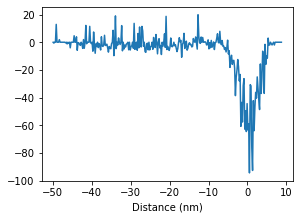

In [28]:
# When this is positive, we are pumping more atoms into the peak than are measured. We also do not add any carbon
# When it is negative, we add carbon
counts_decompose_overlaps_check(df)['24Da excess'].plot()

<AxesSubplot:xlabel='Distance (nm)'>

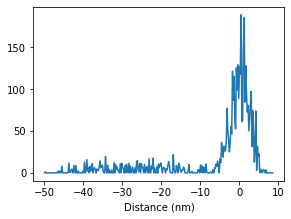

In [29]:
counts_decompose_overlaps_check(df)['C in 24Da'].plot()

<AxesSubplot:xlabel='Distance (nm)'>

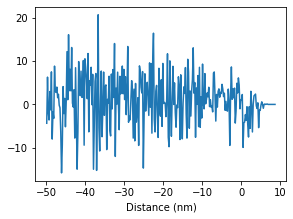

In [30]:
# When this is positive, we are pumping more atoms into the peak than are measured. We also do not add any carbon
# When it is negative, we add carbon
counts_decompose_overlaps_check(df)['25Da excess'].plot()

<AxesSubplot:xlabel='Distance (nm)'>

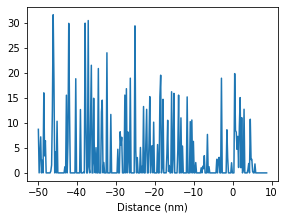

In [31]:
counts_decompose_overlaps_check(df)['C in 25Da'].plot()

<AxesSubplot:xlabel='Distance (nm)'>

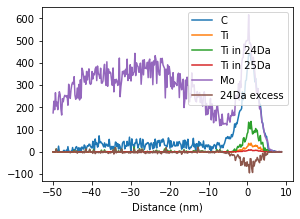

In [32]:
counts_decompose_overlaps_check(df).plot(y = ['C', 'Ti', 'Ti in 24Da', 'Ti in 25Da', 'Mo', '24Da excess'])

<AxesSubplot:xlabel='Distance (nm)'>

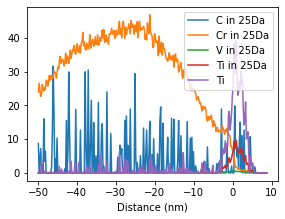

In [33]:
counts_decompose_overlaps_check(df).plot(y = ['C in 25Da', 'Cr in 25Da', 'V in 25Da', 'Ti in 25Da', 'Ti'])

In [35]:
proxigram_counts = counts_decompose_overlaps(df)

/Users/Keith/opt/anaconda3/envs/p38_1/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


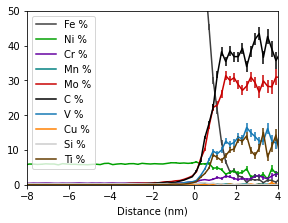

In [36]:
fig = proxigram_plot(
    proxigram(proxigram_counts),
#     show = ['C','Mo'],
    xlim = [-8,4],
    ylim = [0,50],
)

/Users/Keith/opt/anaconda3/envs/p38_1/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


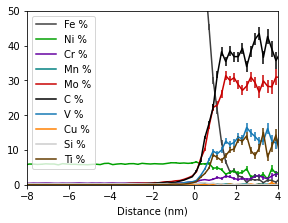

In [38]:
phase = 'small carbides'
xlim = [-8,4]

fig = proxigram_plot(
    proxigram(proxigram_counts),
    xlim = xlim,
    ylim = [0,50],
)

fig.get_figure().savefig('Reports/' + run + phase +'.pdf')

In [ ]:
phase = 'small carbides'
xlim = [-8,4]

fig = proxigram_plot(
    proxigram(proxigram_counts),
    xlim = xlim,
    ylim = [0,50],
)

fig.get_figure().savefig('Reports/' + run + phase +'.pdf')

/Users/Keith/opt/anaconda3/envs/p38_1/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


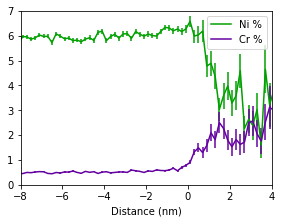

In [39]:
phase = 'small carbides - Ni-Cr'
fig = proxigram_plot(
    proxigram(proxigram_counts),
    show = ['Ni','Cr'],
    xlim = xlim,
    ylim = [0,7],
)

fig.get_figure().savefig('Reports/' + run + phase +'.pdf')

/Users/Keith/opt/anaconda3/envs/p38_1/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


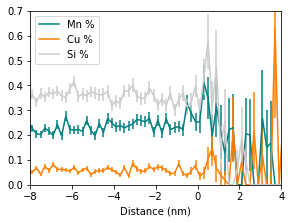

In [41]:
phase = 'small carbides - Mn-Cu-Si'
fig = proxigram_plot(
    proxigram(proxigram_counts),
    show = ['Mn','Cu','Si'],
    xlim = xlim,
    ylim = [0,.7],
)

fig.get_figure().savefig('Reports/' + run + phase +'.pdf')

In [42]:
cutoff = 4
proxigram(proxigram_counts)[:cutoff].to_csv('Reports/R41_01488 proxigram 24Da and 25Da decomposed.csv', index=True)

## Phase compositions

### Carbides

/Users/Keith/opt/anaconda3/envs/p38_1/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


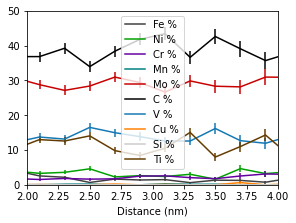

In [43]:
phase = 'carbides'
xlim = [2,4]

proxigram_plot(
    proxigram(proxigram_counts),
#     show = ['C','Mo'],
    xlim = xlim,
    ylim = [0,50],
);


plateau(
    proxigram_counts,
    xlim[0],xlim[1],
).to_csv('Reports/' + run + ' ' + phase + ' x=' + str(xlim) + '.csv')


plateau(
    proxigram_counts,
    xlim[0],xlim[1],
    sorted=True
).to_csv('Reports/' + run + ' ' + phase + ' x=' + str(xlim) + ' sorted.csv')

### Matrix

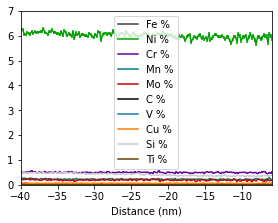

In [47]:
phase = 'carbides'
xlim = [-40,-6]

proxigram_plot(
    proxigram(proxigram_counts),
#     show = ['C','Mo'],
    xlim = xlim,
    ylim = [0,7],
);


plateau(
    proxigram_counts,
    xlim[0],xlim[1],
).to_csv('Reports/' + run + ' ' + phase + ' x=' + str(xlim) + '.csv')


plateau(
    proxigram_counts,
    xlim[0],xlim[1],
    sorted=True
).to_csv('Reports/' + run + ' ' + phase + ' x=' + str(xlim) + ' sorted.csv')